<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_03_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

analyzing words in future dataset

In [15]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


imports for counting words

In [16]:
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [17]:
! pip install transformers -q

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
import seaborn as sns

load nursing notes subject-caregiver-chartdate

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!ls "/content/drive"

MyDrive


In [21]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


In [22]:
patients = "PATIENTS.csv"
df_patients = pd.read_csv(notes_path+patients)
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [23]:
caregivers = "CAREGIVERS.csv"
df_caregivers = pd.read_csv(notes_path+caregivers)
df_caregivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       7567 non-null   int64 
 1   CGID         7567 non-null   int64 
 2   LABEL        7518 non-null   object
 3   DESCRIPTION  5155 non-null   object
dtypes: int64(2), object(2)
memory usage: 236.6+ KB


In [24]:
ward_name = "ICUSTAYS.csv"
df_ward = pd.read_csv(notes_path+ward_name)
df_ward.info()
df_ward['FIRST_CAREUNIT'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


array(['MICU', 'CCU', 'NICU', 'TSICU', 'SICU', 'CSRU'], dtype=object)

In [25]:
icd = "DIAGNOSES_ICD.csv"
df_icd = pd.read_csv(notes_path+icd)
df_icd.columns = df_icd.columns.str.upper()
df_icd = df_icd.dropna(subset=['SEQ_NUM'])
df_icd['SEQ_NUM'] = df_icd['SEQ_NUM'].astype(int)
unique_values = df_icd['SEQ_NUM'].unique()
print("unique_values: ")
print(unique_values)
idx = df_icd.groupby(['HADM_ID', 'SUBJECT_ID'])['SEQ_NUM'].idxmin()
df_icd = df_icd.loc[idx]
df_icd.info()

unique_values: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58929 entries, 462245 to 374673
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      58929 non-null  int64 
 1   SUBJECT_ID  58929 non-null  int64 
 2   HADM_ID     58929 non-null  int64 
 3   SEQ_NUM     58929 non-null  int64 
 4   ICD9_CODE   58929 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


## **Data Preprocessing**

Grab tsicu notes, merge with ward and patients tables

In [26]:
# get new type of notes (TSICU)
df_notes_TSICU = pd.DataFrame()
df_notes_TSICU = df_notes.merge(df_caregivers.drop('ROW_ID', axis=1), on='CGID')
df_notes_TSICU = df_notes_TSICU.merge(df_ward.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_patients.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU[(df_notes_TSICU['FIRST_CAREUNIT'] == 'TSICU') & (df_notes_TSICU['LAST_CAREUNIT'] == 'TSICU')].drop_duplicates()
df_notes_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48469 entries, 23560 to 908511
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48469 non-null  int64  
 1   SUBJECT_ID      48469 non-null  int64  
 2   CGID            48469 non-null  int64  
 3   CHARTDATE       48469 non-null  object 
 4   TEXT            48469 non-null  object 
 5   LABEL           45682 non-null  object 
 6   DESCRIPTION     27859 non-null  object 
 7   HADM_ID         48469 non-null  int64  
 8   ICUSTAY_ID      48469 non-null  int64  
 9   DBSOURCE        48469 non-null  object 
 10  FIRST_CAREUNIT  48469 non-null  object 
 11  LAST_CAREUNIT   48469 non-null  object 
 12  FIRST_WARDID    48469 non-null  int64  
 13  LAST_WARDID     48469 non-null  int64  
 14  INTIME          48469 non-null  object 
 15  OUTTIME         48469 non-null  object 
 16  LOS             48469 non-null  float64
 17  GENDER          48469 non-

In [27]:
df_notes_TSICU.head(5)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,DBSOURCE,...,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
23560,1554291,22312,18679,2127-12-07,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,RN,RN,158950,217912,carevue,...,14,2127-02-06 21:03:30,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1
23562,1554293,22312,18679,2127-12-08,NPN-MICU\nMrs [**Known lastname 662**] has bee...,RN,RN,158950,217912,carevue,...,14,2127-02-06 21:03:30,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1
23564,1554290,22312,20482,2127-02-08,npn\nptis 72 yo female who was admitted for sb...,RN,RN,158950,217912,carevue,...,14,2127-02-06 21:03:30,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1
23566,1554286,22312,18792,2127-02-07,TSICU NSG Admit note\n Mrs. [**Known lastna...,RN,RN,158950,217912,carevue,...,14,2127-02-06 21:03:30,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1
23568,1554292,22312,16021,2127-12-07,pmicu nursing progress note\ngi/heme: pt's ab...,RN,RN,158950,217912,carevue,...,14,2127-02-06 21:03:30,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1


Join with ICD

In [28]:
df_notes_TSICU = df_notes_TSICU.merge(df_icd[['HADM_ID','ICD9_CODE','SEQ_NUM', 'SUBJECT_ID']], on=['HADM_ID', 'SUBJECT_ID'])
df_notes_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48448 non-null  int64  
 1   SUBJECT_ID      48448 non-null  int64  
 2   CGID            48448 non-null  int64  
 3   CHARTDATE       48448 non-null  object 
 4   TEXT            48448 non-null  object 
 5   LABEL           45662 non-null  object 
 6   DESCRIPTION     27848 non-null  object 
 7   HADM_ID         48448 non-null  int64  
 8   ICUSTAY_ID      48448 non-null  int64  
 9   DBSOURCE        48448 non-null  object 
 10  FIRST_CAREUNIT  48448 non-null  object 
 11  LAST_CAREUNIT   48448 non-null  object 
 12  FIRST_WARDID    48448 non-null  int64  
 13  LAST_WARDID     48448 non-null  int64  
 14  INTIME          48448 non-null  object 
 15  OUTTIME         48448 non-null  object 
 16  LOS             48448 non-null  float64
 17  GENDER          48448 non-null 

In [29]:
df_notes_TSICU.head(20)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,DBSOURCE,...,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM
0,1554291,22312,18679,2127-12-07,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
1,1554293,22312,18679,2127-12-08,NPN-MICU\nMrs [**Known lastname 662**] has bee...,RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
2,1554290,22312,20482,2127-02-08,npn\nptis 72 yo female who was admitted for sb...,RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
3,1554286,22312,18792,2127-02-07,TSICU NSG Admit note\n Mrs. [**Known lastna...,RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
4,1554292,22312,16021,2127-12-07,pmicu nursing progress note\ngi/heme: pt's ab...,RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
5,1554289,22312,18592,2127-02-07,"O. Neuro alert oriented x3, mae, fc, pupils re...",RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
6,1554288,22312,15047,2127-02-07,"npn 0700-1500;\nneuro; aoox3 mae to command , ...",RN,RN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
7,1554294,22312,16131,2127-12-08,Nursing Progress Note 0700-1500\nEVENTS: hemod...,RN,NaN,158950,217912,carevue,...,2127-02-08 18:11:56,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1
8,1596599,25658,18679,2179-02-08,NPN-MICU\nMr [**First Name (Titles) 5766**] [*...,RN,RN,172975,290945,carevue,...,2178-10-16 22:47:47,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1
9,1596602,25658,20848,2179-02-09,FOCUS; NURSING PROGRESS NOTE\n68 YEAR OLD MLAE...,RN,NaN,172975,290945,carevue,...,2178-10-16 22:47:47,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1


In [30]:
grouping = df_notes_TSICU.groupby(['CGID','SUBJECT_ID']).size()
df_notes_TSICU['num_of_notes'] = df_notes_TSICU.set_index(['CGID','SUBJECT_ID']).index.map(grouping)
df_notes_TSICU_filtered = df_notes_TSICU[df_notes_TSICU['num_of_notes'] >= 1]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48448 non-null  int64  
 1   SUBJECT_ID      48448 non-null  int64  
 2   CGID            48448 non-null  int64  
 3   CHARTDATE       48448 non-null  object 
 4   TEXT            48448 non-null  object 
 5   LABEL           45662 non-null  object 
 6   DESCRIPTION     27848 non-null  object 
 7   HADM_ID         48448 non-null  int64  
 8   ICUSTAY_ID      48448 non-null  int64  
 9   DBSOURCE        48448 non-null  object 
 10  FIRST_CAREUNIT  48448 non-null  object 
 11  LAST_CAREUNIT   48448 non-null  object 
 12  FIRST_WARDID    48448 non-null  int64  
 13  LAST_WARDID     48448 non-null  int64  
 14  INTIME          48448 non-null  object 
 15  OUTTIME         48448 non-null  object 
 16  LOS             48448 non-null  float64
 17  GENDER          48448 non-null 

In [31]:
df_notes_TSICU_filtered.head(10)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,DBSOURCE,...,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes
0,1554291,22312,18679,2127-12-07,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,2
1,1554293,22312,18679,2127-12-08,NPN-MICU\nMrs [**Known lastname 662**] has bee...,RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,2
2,1554290,22312,20482,2127-02-08,npn\nptis 72 yo female who was admitted for sb...,RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
3,1554286,22312,18792,2127-02-07,TSICU NSG Admit note\n Mrs. [**Known lastna...,RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
4,1554292,22312,16021,2127-12-07,pmicu nursing progress note\ngi/heme: pt's ab...,RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
5,1554289,22312,18592,2127-02-07,"O. Neuro alert oriented x3, mae, fc, pupils re...",RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
6,1554288,22312,15047,2127-02-07,"npn 0700-1500;\nneuro; aoox3 mae to command , ...",RN,RN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
7,1554294,22312,16131,2127-12-08,Nursing Progress Note 0700-1500\nEVENTS: hemod...,RN,NaN,158950,217912,carevue,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,1
8,1596599,25658,18679,2179-02-08,NPN-MICU\nMr [**First Name (Titles) 5766**] [*...,RN,RN,172975,290945,carevue,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,1
9,1596602,25658,20848,2179-02-09,FOCUS; NURSING PROGRESS NOTE\n68 YEAR OLD MLAE...,RN,NaN,172975,290945,carevue,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,1


Filter by number of notes

number of notes: min=1, max=1434, mean=54.86749716874292,  median=16.0


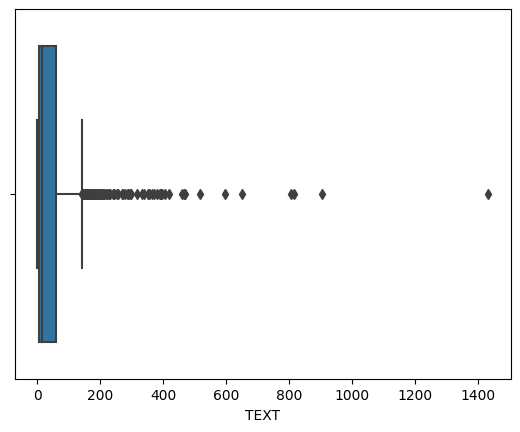

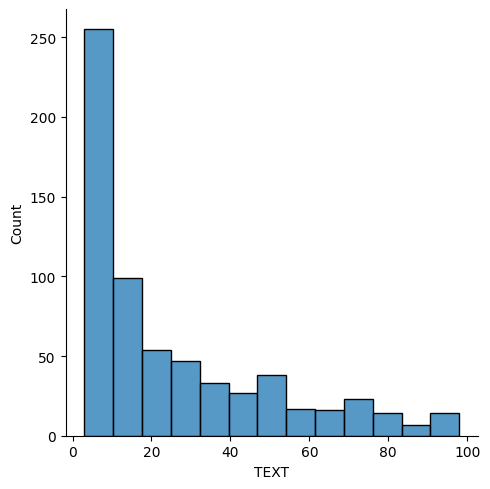

In [32]:
gb_notes = df_notes_TSICU_filtered.groupby(['ICD9_CODE'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<100))])

In [33]:
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          48448 non-null  int64  
 1   SUBJECT_ID      48448 non-null  int64  
 2   CGID            48448 non-null  int64  
 3   CHARTDATE       48448 non-null  object 
 4   TEXT            48448 non-null  object 
 5   LABEL           45662 non-null  object 
 6   DESCRIPTION     27848 non-null  object 
 7   HADM_ID         48448 non-null  int64  
 8   ICUSTAY_ID      48448 non-null  int64  
 9   DBSOURCE        48448 non-null  object 
 10  FIRST_CAREUNIT  48448 non-null  object 
 11  LAST_CAREUNIT   48448 non-null  object 
 12  FIRST_WARDID    48448 non-null  int64  
 13  LAST_WARDID     48448 non-null  int64  
 14  INTIME          48448 non-null  object 
 15  OUTTIME         48448 non-null  object 
 16  LOS             48448 non-null  float64
 17  GENDER          48448 non-null 

In [34]:
drg_grouping = df_notes_TSICU_filtered.groupby(['ICD9_CODE']).size()
df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['ICD9_CODE']).index.map(drg_grouping)
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 1000)]
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 100)]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             48448 non-null  int64  
 1   SUBJECT_ID         48448 non-null  int64  
 2   CGID               48448 non-null  int64  
 3   CHARTDATE          48448 non-null  object 
 4   TEXT               48448 non-null  object 
 5   LABEL              45662 non-null  object 
 6   DESCRIPTION        27848 non-null  object 
 7   HADM_ID            48448 non-null  int64  
 8   ICUSTAY_ID         48448 non-null  int64  
 9   DBSOURCE           48448 non-null  object 
 10  FIRST_CAREUNIT     48448 non-null  object 
 11  LAST_CAREUNIT      48448 non-null  object 
 12  FIRST_WARDID       48448 non-null  int64  
 13  LAST_WARDID        48448 non-null  int64  
 14  INTIME             48448 non-null  object 
 15  OUTTIME            48448 non-null  object 
 16  LOS                484

In [35]:
df_notes_TSICU_dropped_cols = df_notes_TSICU_filtered.drop(['FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID','LAST_WARDID','INTIME', 'OUTTIME', 'DBSOURCE','DOB','DOD','DOD_HOSP','DOD_SSN','CHARTDATE'], axis=1)
df_notes_TSICU_dropped_cols.head(10)

,ROW_ID,SUBJECT_ID,CGID,TEXT,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,LOS,GENDER,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes,num_of_conditions
0,1554291,22312,18679,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,RN,RN,158950,217912,1.8809,F,1,56089,1,2,13
1,1554293,22312,18679,NPN-MICU\nMrs [**Known lastname 662**] has bee...,RN,RN,158950,217912,1.8809,F,1,56089,1,2,13
2,1554290,22312,20482,npn\nptis 72 yo female who was admitted for sb...,RN,RN,158950,217912,1.8809,F,1,56089,1,1,13
3,1554286,22312,18792,TSICU NSG Admit note\n Mrs. [**Known lastna...,RN,RN,158950,217912,1.8809,F,1,56089,1,1,13
4,1554292,22312,16021,pmicu nursing progress note\ngi/heme: pt's ab...,RN,RN,158950,217912,1.8809,F,1,56089,1,1,13
5,1554289,22312,18592,"O. Neuro alert oriented x3, mae, fc, pupils re...",RN,RN,158950,217912,1.8809,F,1,56089,1,1,13
6,1554288,22312,15047,"npn 0700-1500;\nneuro; aoox3 mae to command , ...",RN,RN,158950,217912,1.8809,F,1,56089,1,1,13
7,1554294,22312,16131,Nursing Progress Note 0700-1500\nEVENTS: hemod...,RN,NaN,158950,217912,1.8809,F,1,56089,1,1,13
8,1596599,25658,18679,NPN-MICU\nMr [**First Name (Titles) 5766**] [*...,RN,RN,172975,290945,2.8200,M,1,99661,1,1,73
9,1596602,25658,20848,FOCUS; NURSING PROGRESS NOTE\n68 YEAR OLD MLAE...,RN,NaN,172975,290945,2.8200,M,1,99661,1,1,73


Inverse Document Frequency

In [36]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_notes_TSICU['TEXT'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_score_dict = dict(zip(feature_names, tfidf_scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:50]

In [37]:
print("Rank\tWord\t\t\tCount")
for rank, (word, score) in enumerate(top_words, start=1):
  print(f"{rank}\t{word.ljust(20)}\t{score}")

Rank	Word			Count
1	pt                  	3858.6903894772577
2	hr                  	1471.2297840163665
3	pain                	1164.7940882023267
4	remains             	1117.4422691304126
5	cont                	1066.8040470247731
6	ni                  	1064.6198456445675
7	clear               	1048.9647714021357
8	resp                	1043.7994178984986
9	neuro               	1034.694601057851
10	plan                	1028.8010630778783
11	given               	1027.131281857696
12	today               	1025.5294101764566
13	noted               	1000.4239611589693
14	skin                	998.9591517978259
15	care                	981.4243721169329
16	bs                  	980.7880331487136
17	stable              	963.3350924689521
18	family              	932.8899041885629
19	intact              	924.4465732530525
20	abd                 	916.9799870140897
21	vent                	901.7520471083034
22	100                 	875.3529533254998
23	monitor             	868.2895431277631
24	secretions 

select emotional words then filter rows that dont have a minimum number of them

In [38]:
def filter_for_emotional_words(df):
  selected_words = ['pain', 'family', 'stable', 'care', 'well', 'social', 'support', 'able', 'decreased', 'warm', 'unable', 'strong', 'intact', 'good', 'times', 'aware', 'eyes', 'tolerated', 'denies', 'tolerating', 'please', 'palpable']
  print("selected_words list length: ", len(selected_words))
  pattern = '|'.join(selected_words)
  new_df = df[df['TEXT'].str.contains(pattern, regex=True)].copy()
  #filtered_data = df_notes_TSICU[df_notes_TSICU['TEXT'].str.contains(pattern, regex=True)].copy()
  new_df['num_search_words'] = new_df['TEXT'].str.count(pattern)
  #new_df = new_df[new_df['num_search_words'] >= 0]
  new_df.info()
  return new_df

In [39]:
#filtered_data = filter_for_emotional_words(df_notes_TSICU_dropped_cols)
filtered_data = df_notes_TSICU_dropped_cols

Random selection from sample set

In [40]:
#random_filtered_data = filtered_data.sample(n=50000, random_state=42)
random_filtered_data = filtered_data

Remove similar sentences

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def remove_similar_notes(df):
  sentences = df['TEXT'].tolist()
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform(sentences)
  similarity_threshold = 0.8

  similar_indices = []
  for i, sentence in enumerate(sentences):  # needs to be max 1000 entries
    if any(cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0] > similarity_threshold for j in range(i)):  # very slow ~10 minutes for 1000 entries, exponential complexity (more than 5 hours if 6000 entries)
      similar_indices.append(i)
  index_labels = df.index[similar_indices]
  df.drop(index_labels, inplace=True)
  return df

In [42]:
#random_filtered_data = remove_similar_notes(random_filtered_data)
random_filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48448 entries, 0 to 48447
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             48448 non-null  int64  
 1   SUBJECT_ID         48448 non-null  int64  
 2   CGID               48448 non-null  int64  
 3   TEXT               48448 non-null  object 
 4   LABEL              45662 non-null  object 
 5   DESCRIPTION        27848 non-null  object 
 6   HADM_ID            48448 non-null  int64  
 7   ICUSTAY_ID         48448 non-null  int64  
 8   LOS                48448 non-null  float64
 9   GENDER             48448 non-null  object 
 10  EXPIRE_FLAG        48448 non-null  int64  
 11  ICD9_CODE          48448 non-null  object 
 12  SEQ_NUM            48448 non-null  int64  
 13  num_of_notes       48448 non-null  int64  
 14  num_of_conditions  48448 non-null  int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 5.9+ MB


Find matching conditions for both expired flags

In [43]:
def split_set_half_expired(df):
  df['EXPIRE_FLAG'] = df['EXPIRE_FLAG'].astype(int)
  group_conditions = df.groupby(['ICD9_CODE', 'EXPIRE_FLAG'])
  def balance_conditions(g1,g2,size):
    size = min(len(g1), len(g2), size)
    return g1.sample(n=size, random_state=1), g2.sample(n=size, random_state=1)

  rows = []
  size = 50000

  for drg_desc, group in group_conditions:
    icd9, expire = drg_desc
    if (icd9, 1-expire) in group_conditions.groups:
      paired_group = group_conditions.get_group((icd9, 1-expire))
      group_sample1, group_sample2 = balance_conditions(group, paired_group, size)
      rows.append(group_sample1)
      rows.append(group_sample2)
      size -= len(group_sample1)
    if size <= 0:
      break

  new_df = pd.concat(rows)
  new_df = new_df.drop_duplicates()

  new_df.info()
  #print(new_df[['ICD9_CODE', 'EXPIRE_FLAG']])
  return new_df

  #valid_groups = [key for key, group in group_conditions.groups.keys() if (key[0], key[1], 1 - key[2]) in group_conditions.groups]
  #for key in valid_groups:
    #pass

In [44]:
#balanced_data = split_set_half_expired(random_filtered_data)
balanced_data = random_filtered_data

Display notes

In [45]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', None)
#print(balanced_data['TEXT'].head(200))
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [46]:
print(balanced_data.columns)
print(balanced_data.count)

Index(['ROW_ID', 'SUBJECT_ID', 'CGID', 'TEXT', 'LABEL', 'DESCRIPTION',
       'HADM_ID', 'ICUSTAY_ID', 'LOS', 'GENDER', 'EXPIRE_FLAG', 'ICD9_CODE',
       'SEQ_NUM', 'num_of_notes', 'num_of_conditions'],
      dtype='object')
<bound method DataFrame.count of         ROW_ID  SUBJECT_ID   CGID  \
0      1554291       22312  18679   
1      1554293       22312  18679   
2      1554290       22312  20482   
3      1554286       22312  18792   
4      1554292       22312  16021   
...        ...         ...    ...   
48443  1484815       16986  17585   
48444  1484816       16986  17487   
48445  1362638        7477  18800   
48446  1675356       32679  14973   
48447  1675357       32679  20705   

                                                    TEXT LABEL DESCRIPTION  \
0      NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...    RN          RN   
1      NPN-MICU\nMrs [**Known lastname 662**] has bee...    RN          RN   
2      npn\nptis 72 yo female who was admitted for sb...    RN

Save to CSV

In [47]:
# path and name of the cvs file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_TSICU_COUNTS.csv'
balanced_data.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)

deceased patients for unfiltered set

In [48]:
len(df_notes_TSICU['SUBJECT_ID'].unique())
deceased_TSICU = df_notes_TSICU[df_notes_TSICU['EXPIRE_FLAG'] == 1]
deceased_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26007 entries, 0 to 48440
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          26007 non-null  int64  
 1   SUBJECT_ID      26007 non-null  int64  
 2   CGID            26007 non-null  int64  
 3   CHARTDATE       26007 non-null  object 
 4   TEXT            26007 non-null  object 
 5   LABEL           24425 non-null  object 
 6   DESCRIPTION     15027 non-null  object 
 7   HADM_ID         26007 non-null  int64  
 8   ICUSTAY_ID      26007 non-null  int64  
 9   DBSOURCE        26007 non-null  object 
 10  FIRST_CAREUNIT  26007 non-null  object 
 11  LAST_CAREUNIT   26007 non-null  object 
 12  FIRST_WARDID    26007 non-null  int64  
 13  LAST_WARDID     26007 non-null  int64  
 14  INTIME          26007 non-null  object 
 15  OUTTIME         26007 non-null  object 
 16  LOS             26007 non-null  float64
 17  GENDER          26007 non-null 

CGID   SUBJECT_ID
14020  27301          1
       27755          1
       28447          2
       29414          4
       29691          1
                     ..
21570  26224          7
       26294          2
       26308          2
       26419          4
       26429         10
Name: TEXT, Length: 12108, dtype: int64
number of notes: min=1, max=124, mean=2.1479187314172448,  median=1.0


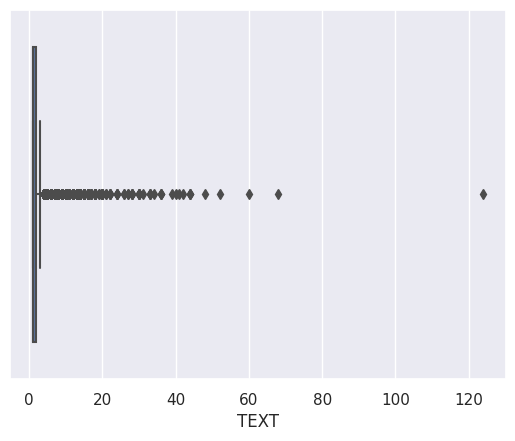

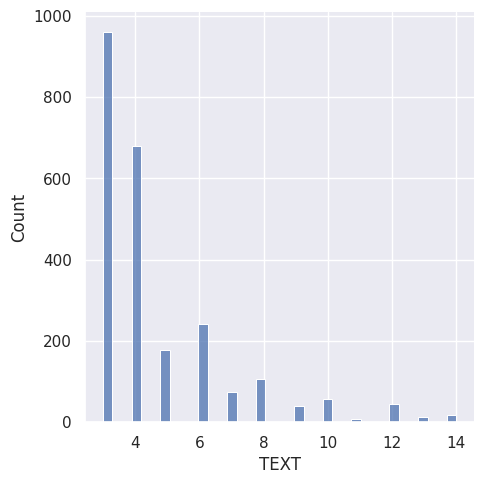

In [49]:
sns.set()

gb_notes = deceased_TSICU.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()
print(num_notes)
print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

Seperate deceased and living

In [50]:
deceased_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 1]
deceased_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26007 entries, 0 to 48440
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             26007 non-null  int64  
 1   SUBJECT_ID         26007 non-null  int64  
 2   CGID               26007 non-null  int64  
 3   TEXT               26007 non-null  object 
 4   LABEL              24425 non-null  object 
 5   DESCRIPTION        15027 non-null  object 
 6   HADM_ID            26007 non-null  int64  
 7   ICUSTAY_ID         26007 non-null  int64  
 8   LOS                26007 non-null  float64
 9   GENDER             26007 non-null  object 
 10  EXPIRE_FLAG        26007 non-null  int64  
 11  ICD9_CODE          26007 non-null  object 
 12  SEQ_NUM            26007 non-null  int64  
 13  num_of_notes       26007 non-null  int64  
 14  num_of_conditions  26007 non-null  int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 3.2+ MB


In [51]:
living_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 0]
living_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 77 to 48447
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             22441 non-null  int64  
 1   SUBJECT_ID         22441 non-null  int64  
 2   CGID               22441 non-null  int64  
 3   TEXT               22441 non-null  object 
 4   LABEL              21237 non-null  object 
 5   DESCRIPTION        12821 non-null  object 
 6   HADM_ID            22441 non-null  int64  
 7   ICUSTAY_ID         22441 non-null  int64  
 8   LOS                22441 non-null  float64
 9   GENDER             22441 non-null  object 
 10  EXPIRE_FLAG        22441 non-null  int64  
 11  ICD9_CODE          22441 non-null  object 
 12  SEQ_NUM            22441 non-null  int64  
 13  num_of_notes       22441 non-null  int64  
 14  num_of_conditions  22441 non-null  int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 2.7+ MB


Tokenized words

In [52]:
#text = df_notes_TSICU['TEXT'].str.cat(sep=' ')
#words = nltk.word_tokenize(text)  # very slow

Count words in notes

In [53]:
#stopwords = nltk.corpus.stopwords.words('english')
#words = [word.lower() for word in words if word.lower() not in stopwords and re.match(r'\b\w+\b', word)]  # also slow but only kinda slow
#word_counts = Counter(words)
#most_common_words = word_counts.most_common(300)

In [54]:
#print("Rank\tWord\t\t\tCount")
#for rank, word_count in enumerate(most_common_words, start=1):
  #word, count = word_count
  #print(f"{rank}\t{word.ljust(20)}\t{count}")

Emotional words

In [55]:
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #synsets = wn.synsets(word)
  #if synsets:
    #senti_synset = swn.senti_synset(synsets[0].name())
    #if senti_synset.pos_score() > 0.45 or senti_synset.neg_score() > 0.45:
      #emotional_words.append(word)

#emotional_words

In [56]:
#from textblob import TextBlob
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #tb = TextBlob(word)
  #sentiment = tb.sentiment.polarity
  #if abs(sentiment) > 0.35:
    #emotional_words.append(word)

#emotional_words